In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import torch
from tqdm import tqdm

from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")



There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [2]:
from my_model import CustomModel, PT5_classification_model, train_per_protein, create_dataset, load_model_

[2024-09-05 02:47:21,040] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
import umap
import matplotlib.pyplot as plt

In [4]:
import umap.plot  



/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [5]:
from epitopes.utilites import *

In [6]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)


In [7]:
import os.path
#os.chdir("./")
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [8]:
# def process_types(string, typ = 'A'):
    
#     pattern = f'[A-Z]+?\d+'
#     res = re.search(pattern, string)[0]
#     return res#.replace(typ, '', 1)


# def add_spaces(seq):
#      return ' '.join(list(seq))

# def balance_majority(genes: pd.DataFrame, colu, min_count=30, max_count=1500):
#     counts = genes[colu].value_counts()
#     counts = counts.drop(counts[min_count>counts].index)
#     resampled = pd.DataFrame()
#     #print(resampled)
#     maj_clss = (counts[counts>max_count]).index
#     left_genes = pd.DataFrame()
#     mean_clss = counts[(counts<max_count) & (min_count<counts)].index#[i for i in genes[colu] if i not in min_classes]
#     #print(mean_clss)
#     for cl in mean_clss:
#         #print(cl)
#         left_genes = pd.concat([left_genes, genes[genes[colu]==cl]])

#     for maj_cl in maj_clss:
#         #print(maj_cl)
        
#         resampled = pd.concat([resampled, resample(genes[genes[colu] == maj_cl], replace=False, n_samples=max_count, random_state=42)])
#         #genes = genes.drop(genes[genes[colu]==maj_cl].index)
#     return pd.concat([left_genes, resampled])

In [9]:
# def load_model_(filepath, mod_type='Prottrans', num_labels=1, mixed = False):
#     if mod_type=='Prottrans':
#         my_model, tokenizer = PT5_classification_model(num_labels=num_labels, half_precision=mixed)
        
        
#     elif mod_type=='TCR-bert':
#         # tokenizer = BertTokenizer.from_pretrained("wukevin/tcr-bert", do_lower_case=False );
#         # model = BertForSequenceClassification.from_pretrained("wukevin/tcr-bert", num_labels = num_labels);
#         my_model = CustomModel()
        
    
#     # Load the non-frozen parameters from the saved file
#     non_frozen_params = torch.load(filepath)

#     # Assign the non-frozen parameters to the corresponding parameters of the model
#     for param_name, param in my_model.named_parameters():
#         if param_name in non_frozen_params:
#             param.data = non_frozen_params[param_name].data

#     return my_model if mod_type=='TCR-bert' else (tokenizer, my_model)

In [10]:
mapping_v = {'TRAV1': 0, 'TRAV10': 1, 'TRAV12': 2,  'TRAV13': 3, 'TRAV14': 4, 'TRAV16': 5, 'TRAV17': 6, 'TRAV2': 7,
 'TRAV20': 8, 'TRAV21': 9, 'TRAV22': 10, 'TRAV23': 11, 'TRAV24': 12, 'TRAV25': 13, 'TRAV26': 14, 'TRAV27': 15,
 'TRAV29': 16, 'TRAV34': 17, 'TRAV35': 18, 'TRAV36': 19, 'TRAV38': 20, 'TRAV39': 21, 'TRAV4': 22, 'TRAV40': 23,
 'TRAV41': 24, 'TRAV5': 25, 'TRAV6': 26, 'TRAV8': 27, 'TRAV9': 28, 'TRBV10': 29, 'TRBV11': 30, 'TRBV12': 31,
 'TRBV14': 32, 'TRBV18': 33, 'TRBV19': 34, 'TRBV2': 35, 'TRBV20': 36, 'TRBV21': 37, 'TRBV24': 38, 'TRBV27': 39,
 'TRBV28': 40, 'TRBV29': 41, 'TRBV30': 42, 'TRBV4': 43, 'TRBV5': 44, 'TRBV6': 45, 'TRBV7': 46, 'TRBV9': 47}

In [11]:
N_LABELS_v = 48
# tokenizer_prottrans, model_prottrans = load_model_("./Prottrans_v_genes_finetuned.pth", num_labels=N_LABELS_v, mixed=False)

In [12]:
model_tcr = load_model_("models_ft/TCR_bert_v_genes_finetuned.pth", mod_type='TCR-bert', num_labels=N_LABELS_v)

Some weights of the model checkpoint at wukevin/tcr-bert-mlm-only were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert-ml

In [13]:
model_tcr.maximun_len = 25

In [14]:
alpha_data = pd.read_csv('data/selected_cdr_alpha_440002200808_S159_L002.csv', index_col=0)
beta_data = pd.read_csv('data/selected_cdr_beta_440001980101_S87_L001.csv', index_col=0)


alpha_data['v'] = alpha_data['v'].apply(process_types, 'A')
beta_data['v'] = beta_data['v'].apply(process_types, 'B')

curr_data_A = alpha_data[['cdr3aa', 'v']]
curr_data_B = beta_data[['cdr3aa', 'v']]

curr_data_A['cdr3aa'] = curr_data_A['cdr3aa'].apply(add_spaces)
curr_data_B['cdr3aa'] = curr_data_B['cdr3aa'].apply(add_spaces)

curr_data_A = balance_majority(curr_data_A, 'v', min_count=100, max_count=500)
curr_data_B = balance_majority(curr_data_B, 'v', min_count=100, max_count=1000)

/scratch/ipykernel_2639042/2676773025.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data_A['cdr3aa'] = curr_data_A['cdr3aa'].apply(add_spaces)
/scratch/ipykernel_2639042/2676773025.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data_B['cdr3aa'] = curr_data_B['cdr3aa'].apply(add_spaces)


In [15]:
hid_sts = []
hid_sts_med = []
lbls = []
hid_sts_long = []
model_tcr.to(device)

for seq in tqdm(curr_data_A.index):
    seq, lab = curr_data_A.loc[seq]#, v_ans.loc[seq]
    en_dict = model_tcr.tokenizer.encode_plus(seq, add_special_tokens = True, 
                                      max_length = 25, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
    input_ids_test, att_mask_test = en_dict['input_ids'], en_dict['attention_mask']
    #my_model.model.eval()

    input_ids_test = input_ids_test.to(device)
    att_mask_test= att_mask_test.to(device)
    #lab = torch.tensor(lab).to(device)

    with torch.no_grad():
        outputs = model_tcr.model(input_ids_test, att_mask_test, output_hidden_states=True)
        
    hid_sts.append([torch.mean(tensor).item() for tensor in outputs.hidden_states])
    #hid_sts_med.append([torch.median(tensor).item() for tensor in outputs.hidden_states])
    lbls.append(lab)
    emb = torch.mean(torch.mean(torch.mean(torch.stack(list(outputs.hidden_states)), dim=2), dim=1), dim =0)
    hid_sts_long.append(emb.tolist())

  0%|          | 0/11768 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 11768/11768 [02:04<00:

<AxesSubplot: >

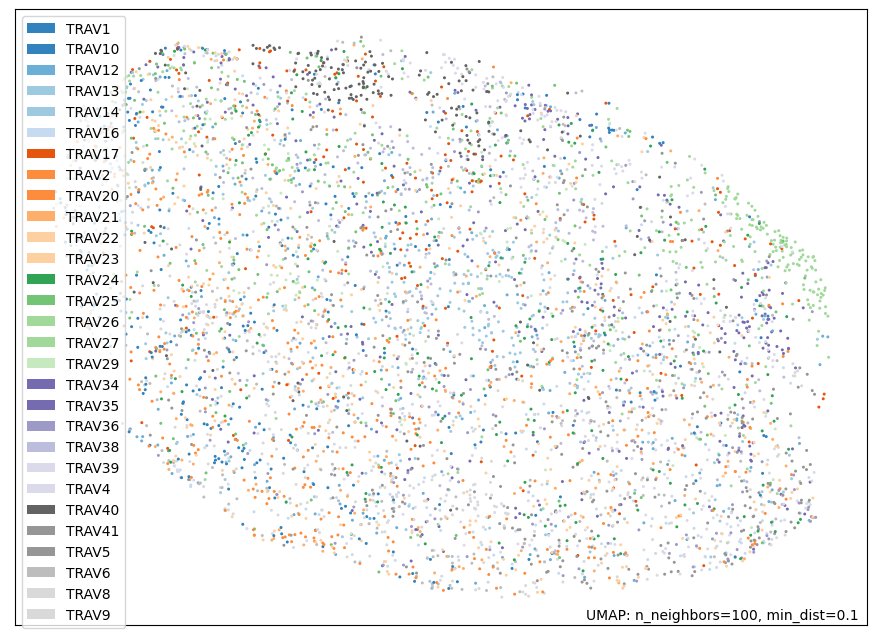

In [106]:
reduced_AV = umap.UMAP(n_neighbors=100, min_dist=0.1).fit(hid_sts)

umap.plot.points(reduced_AV, labels=np.array(lbls), theme='green', width=1100)

In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

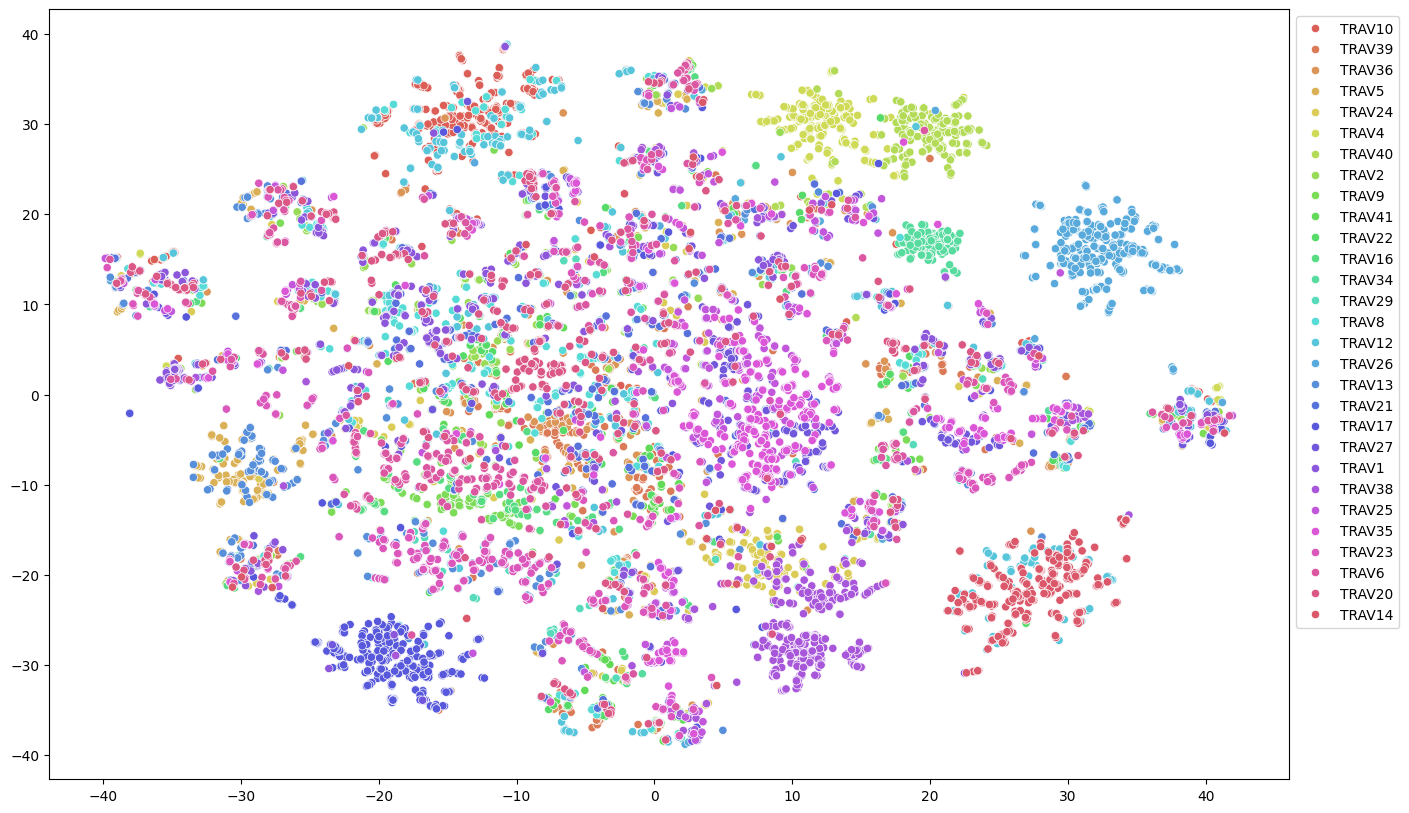

In [19]:
# pca = PCA(n_components=80)#(hid_sts)
# pca_embedding = pca.fit_transform(hid_sts_long)



# tsne = TSNE(n_components=2, n_iter=500, perplexity=80, verbose=1, init=pca_embedding[:, :2], n_jobs=-1)
# tsne_results = tsne.fit_transform(pca_embedding)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=lbls,
    palette=sns.color_palette("hls", 29),
    legend="full",
    alpha=1
)
# plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [20]:
hid_sts_B = []
# hid_sts_med = []
lbls_B = []
hid_sts_long = []
model_tcr.to(device)

for seq in tqdm(curr_data_B.index):
    seq, lab = curr_data_B.loc[seq]#, v_ans.loc[seq]
    en_dict = model_tcr.tokenizer.encode_plus(seq, add_special_tokens = True, 
                                      max_length = 25, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
    input_ids_test, att_mask_test = en_dict['input_ids'], en_dict['attention_mask']
    #my_model.model.eval()

    input_ids_test = input_ids_test.to(device)
    att_mask_test= att_mask_test.to(device)
    #lab = torch.tensor(lab).to(device)

    with torch.no_grad():
        outputs = model_tcr.model(input_ids_test, att_mask_test, output_hidden_states=True)
        
    hid_sts_B.append([torch.mean(tensor).item() for tensor in outputs.hidden_states])
    #hid_sts_med.append([torch.median(tensor).item() for tensor in outputs.hidden_states])
    lbls_B.append(lab)
    emb = torch.mean(torch.mean(torch.mean(torch.stack(list(outputs.hidden_states)), dim=2), dim=1), dim =0)
    hid_sts_long.append(emb.tolist())

  0%|          | 0/15963 [00:00<?, ?it/s]/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 15963/15963 [02:48<00:00, 94.63it/s]


<AxesSubplot: >

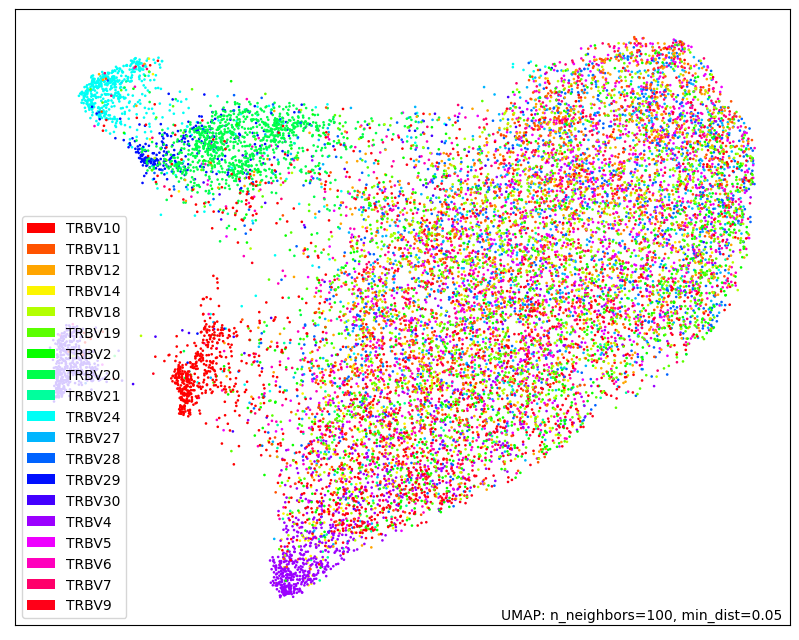

In [144]:
reduced = umap.UMAP(n_neighbors=100, min_dist=0.05).fit(hid_sts_B)

umap.plot.points(reduced, labels=np.array(lbls_B), color_key_cmap='hsv', width=1000)


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f2ebb8f6f70>
Traceback (most recent call last):
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 15963 samples in 0.004s...
[t-SNE] Computed neighbors for 15963 samples in 0.994s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15963
[t-SNE] Computed conditional probabilities for sample 2000 / 15963
[t-SNE] Computed conditional probabilities for sample 3000 / 15963
[t-SNE] Computed conditional probabilities for sample 4000 / 15963
[t-SNE] Computed conditional probabilities for sample 5000 / 15963
[t-SNE] Computed conditional probabilities for sample 6000 / 15963
[t-SNE] Computed conditional probabilities for sample 7000 / 15963
[t-SNE] Computed conditional probabilities for sample 8000 / 15963
[t-SNE] Computed conditional probabilities for sample 9000 / 15963
[t-SNE] Computed conditional probabilities for sample 10000 / 15963
[t-SNE] Computed conditional probabilities for sample 11000 / 15963
[t-SNE] Computed conditional probabilities for sample 12000 / 15963
[t-SNE] Computed conditional probabilities for sa

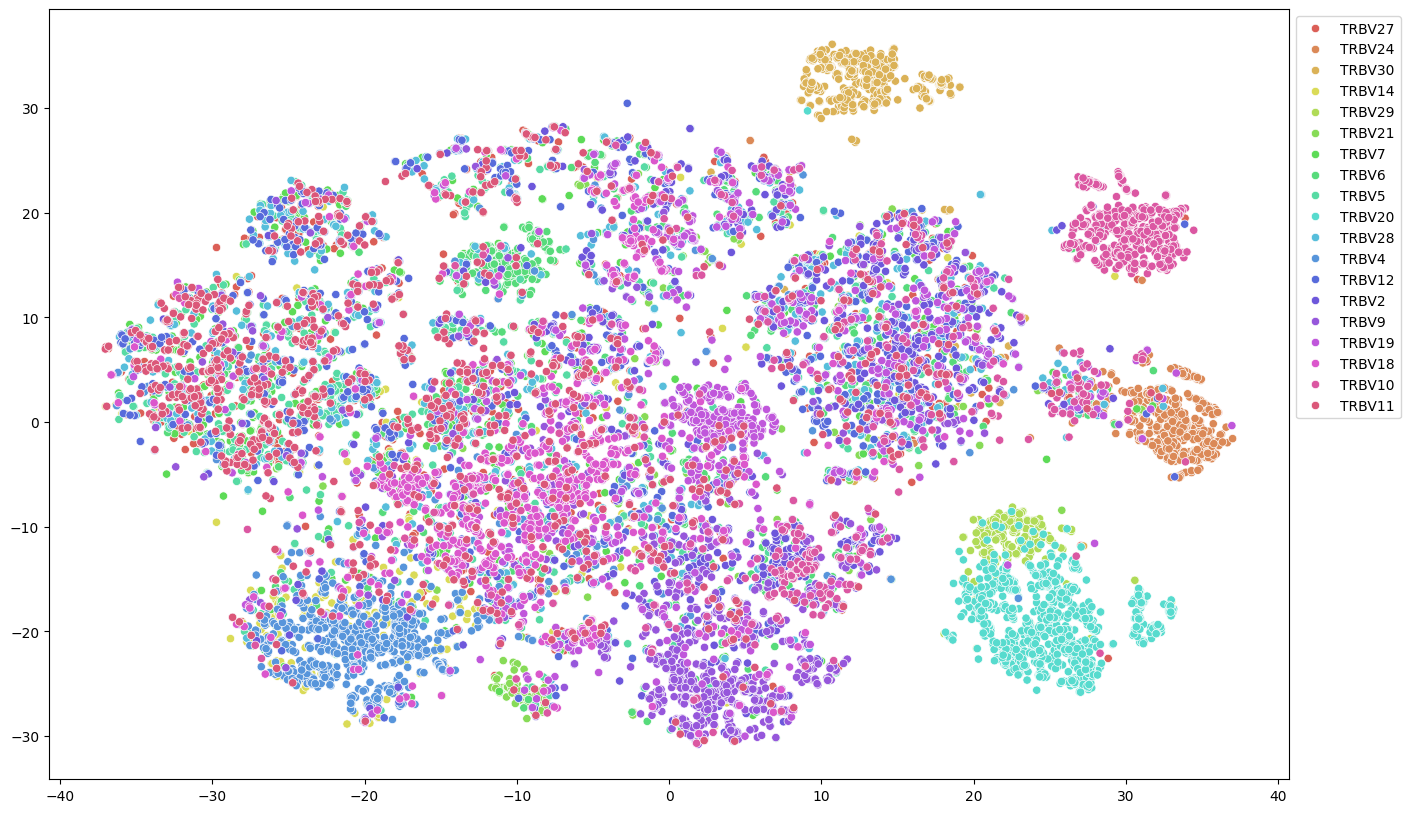

In [21]:
pca = PCA(n_components=80)#(hid_sts)
pca_embedding = pca.fit_transform(hid_sts_long)

tsne = TSNE(n_components=2, n_iter=500, perplexity=80, verbose=1, init=pca_embedding[:, :2], n_jobs=-1)
tsne_results = tsne.fit_transform(pca_embedding)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=lbls_B,
    palette=sns.color_palette("hls", 19),
    legend="full",
    alpha=1
)
# plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [32]:
# j genes

In [31]:
alpha_data = pd.read_csv('data/selected_cdr_alpha_440002200808_S159_L002.csv', index_col=0)
beta_data = pd.read_csv('data/selected_cdr_beta_440001980101_S87_L001.csv', index_col=0)


alpha_data['j'] = alpha_data['j'].apply(process_types, 'A')
beta_data['j'] = beta_data['j'].apply(process_types, 'B')

curr_data_A_j = alpha_data[['cdr3aa', 'j']]
curr_data_B_j = beta_data[['cdr3aa', 'j']]

curr_data_A_j['cdr3aa'] = curr_data_A_j['cdr3aa'].apply(add_spaces)
curr_data_B_j['cdr3aa'] = curr_data_B_j['cdr3aa'].apply(add_spaces)

curr_data_A_j = balance_majority(curr_data_A_j, 'j', min_count=100, max_count=500)
curr_data_B_j = balance_majority(curr_data_B_j, 'j', min_count=100, max_count=500)

/scratch/ipykernel_2335527/3976454421.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data_A_j['cdr3aa'] = curr_data_A_j['cdr3aa'].apply(add_spaces)
/scratch/ipykernel_2335527/3976454421.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_data_B_j['cdr3aa'] = curr_data_B_j['cdr3aa'].apply(add_spaces)


In [32]:
mapping_j = {'TRAJ10': 0, 'TRAJ11': 1, 'TRAJ12': 2, 'TRAJ13': 3, 'TRAJ15': 4, 'TRAJ16': 5, 'TRAJ17': 6, 'TRAJ18': 7,
 'TRAJ20': 8, 'TRAJ23': 9, 'TRAJ24': 10, 'TRAJ27': 11, 'TRAJ28': 12, 'TRAJ29': 13, 'TRAJ31': 14, 'TRAJ32': 15,
 'TRAJ33': 16, 'TRAJ35': 17, 'TRAJ36': 18, 'TRAJ37': 19, 'TRAJ39': 20, 'TRAJ4': 21, 'TRAJ40': 22, 'TRAJ41': 23,
 'TRAJ42': 24, 'TRAJ43': 25, 'TRAJ44': 26, 'TRAJ45': 27, 'TRAJ48': 28, 'TRAJ49': 29, 'TRAJ50': 30,'TRAJ52': 31,
 'TRAJ53': 32, 'TRAJ54': 33, 'TRAJ56': 34, 'TRAJ6': 35, 'TRAJ61': 36, 'TRAJ7': 37, 'TRAJ9': 38, 'TRBJ1': 39, 'TRBJ2': 40}

In [34]:
N_LABELS_j = 41
model_tcr_j = load_model_('models_ft/TCR_bert_j_genes.pth',  mod_type='TCR-bert', num_labels=N_LABELS_j)
model_tcr_j.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([41, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([41]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [35]:
hid_sts_Aj = []
lbls_Aj = []
hid_sts_long = []
model_tcr_j.to(device)

for seq in tqdm(curr_data_A_j.index):
    seq, lab = curr_data_A_j.loc[seq]#, v_ans.loc[seq]
    en_dict = model_tcr_j.tokenizer.encode_plus(seq, add_special_tokens = True, 
                                      max_length = 25, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
    input_ids_test, att_mask_test = en_dict['input_ids'], en_dict['attention_mask']
    #my_model.model.eval()

    input_ids_test = input_ids_test.to(device)
    att_mask_test= att_mask_test.to(device)
    #lab = torch.tensor(lab).to(device)

    with torch.no_grad():
        outputs = model_tcr_j.model(input_ids_test, att_mask_test, output_hidden_states=True)
        
    hid_sts_Aj.append([torch.mean(tensor).item() for tensor in outputs.hidden_states])
    
    lbls_Aj.append(lab)
    emb = torch.mean(torch.mean(torch.mean(torch.stack(list(outputs.hidden_states)), dim=2), dim=1), dim =0)
    hid_sts_long.append(emb.tolist())

  0%|          | 0/16295 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 16295/16295 [02:50<00:

In [17]:
# umap_vis_3d(hid_sts_Aj, lbls_Aj, mapping_j)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<AxesSubplot: >

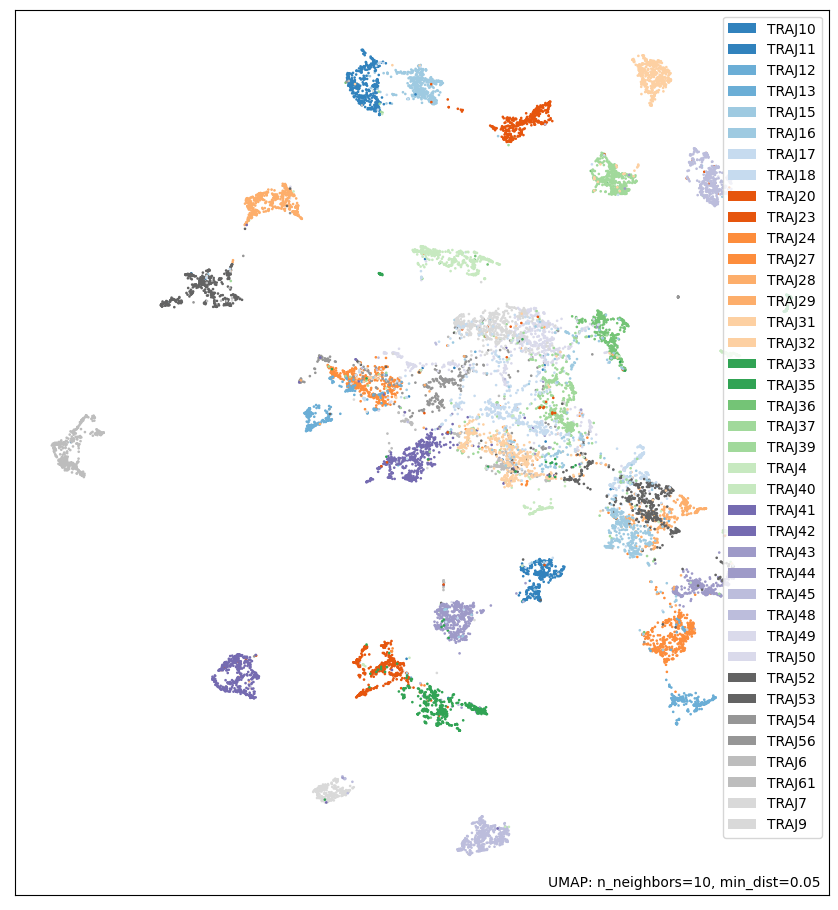

In [14]:
reduced = umap.UMAP(n_neighbors=10, min_dist=0.05).fit(hid_sts_Aj)

umap.plot.points(reduced, labels=np.array(lbls_Aj), theme='green', width=1050, height=1150)
#plt.legend(bbox_to_anchor=(1, 1.05), loc=2)


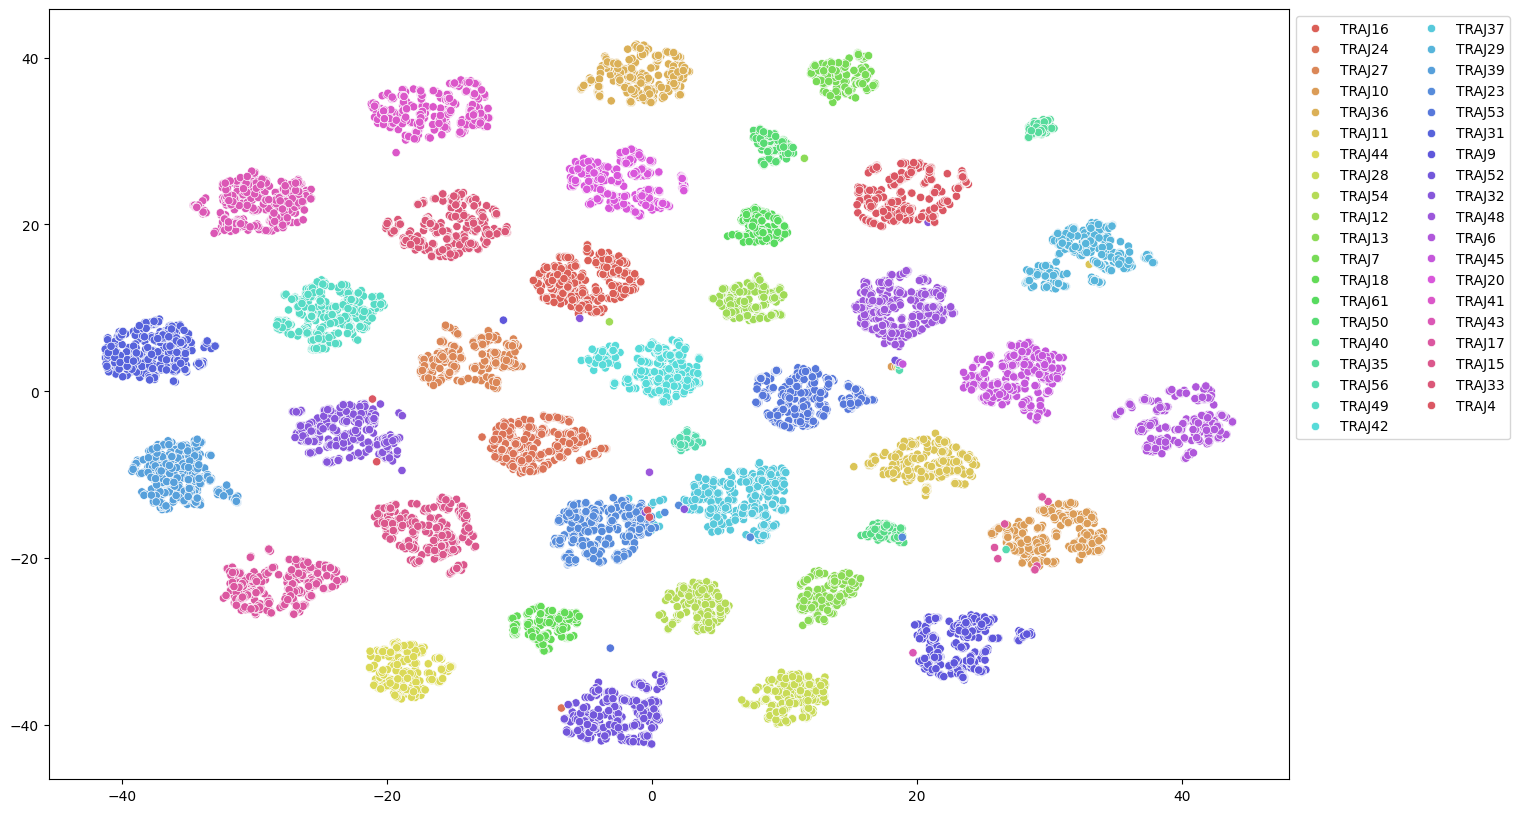

In [41]:
pca = PCA(n_components=80)#(hid_sts)
pca_embedding = pca.fit_transform(hid_sts_long)

tsne = TSNE(n_components=2, n_iter=500, perplexity=80, verbose=1, init=pca_embedding[:, :2], n_jobs=-1)
tsne_results = tsne.fit_transform(pca_embedding)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=lbls_Aj,
    palette=sns.color_palette("hls", 39),
    legend="full",
    alpha=1
)
# plt.legend(loc='upper left')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 2)

In [42]:
hid_sts_Bj = []
lbls_Bj = []
hid_sts_long = []
model_tcr_j.to(device)

for seq in tqdm(curr_data_B_j.index):
    seq, lab = curr_data_B_j.loc[seq]#, v_ans.loc[seq]
    en_dict = model_tcr_j.tokenizer.encode_plus(seq, add_special_tokens = True, 
                                      max_length = 25, pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
    input_ids_test, att_mask_test = en_dict['input_ids'], en_dict['attention_mask']
    #my_model.model.eval()

    input_ids_test = input_ids_test.to(device)
    att_mask_test= att_mask_test.to(device)
    #lab = torch.tensor(lab).to(device)

    with torch.no_grad():
        outputs = model_tcr_j.model(input_ids_test, att_mask_test, output_hidden_states=True)
        
    hid_sts_Bj.append([torch.mean(tensor).item() for tensor in outputs.hidden_states])
    #hid_sts_med.append([torch.median(tensor).item() for tensor in outputs.hidden_states])
    lbls_Bj.append(lab)
    emb = torch.mean(torch.mean(torch.mean(torch.stack(list(outputs.hidden_states)), dim=2), dim=1), dim =0)
    hid_sts_long.append(emb.tolist())

  0%|          | 0/1000 [00:00<?, ?it/s]/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1000/1000 [00:10<00:00, 92.08it/s]


In [ ]:
reduced = umap.UMAP(n_neighbors=20, min_dist=0.1).fit(hid_sts_Bj)

umap.plot.points(reduced, labels=np.array(lbls_Bj), height=500, alpha=1, color_key_cmap='winter')

NameError: name 'umap' is not defined

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f546dbc45e0>
Traceback (most recent call last):
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.117s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.270737
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.553822
[t-SNE] KL divergence after 500 iterations: 0.609452


/scratch/ipykernel_2335527/3784820442.py:7: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


<AxesSubplot: >

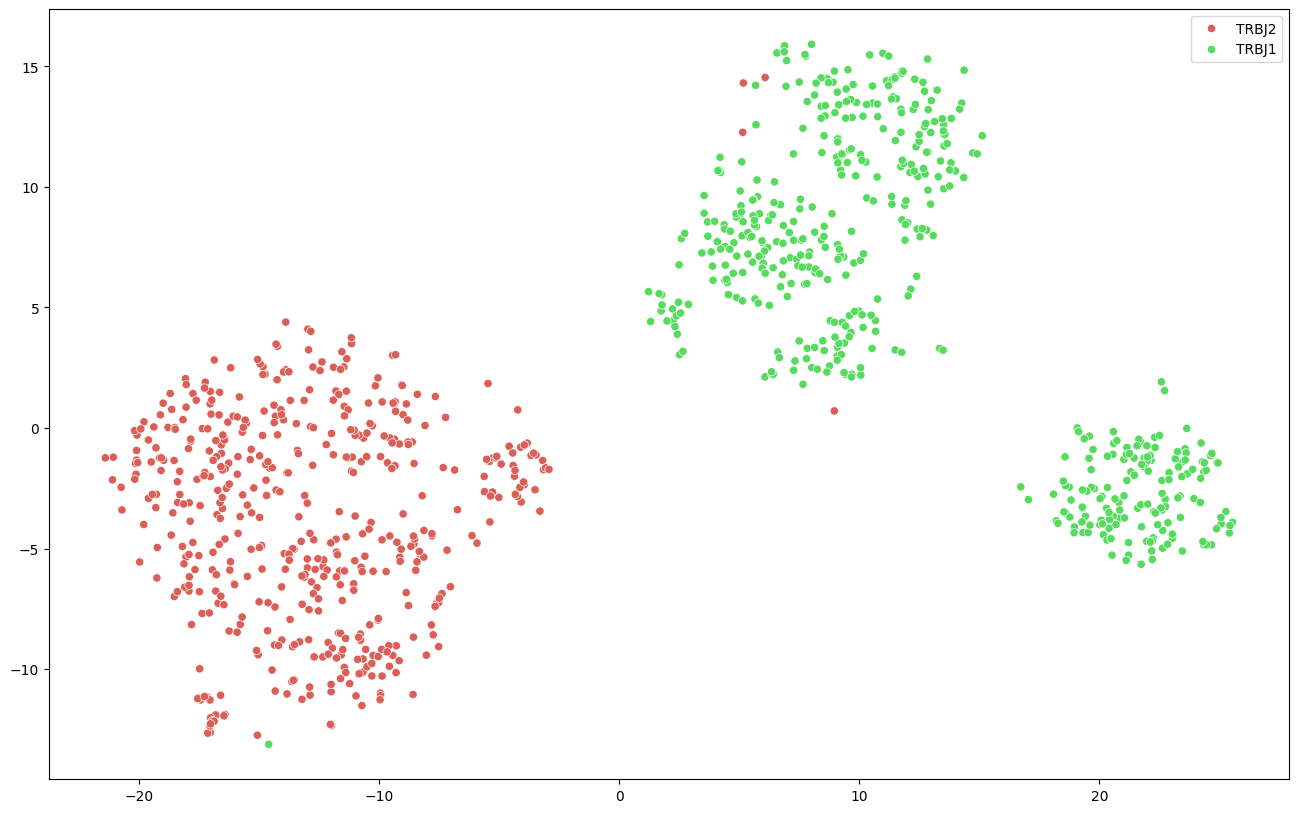

In [44]:
pca = PCA(n_components=80)#(hid_sts)
pca_embedding = pca.fit_transform(hid_sts_long)

tsne = TSNE(n_components=2, n_iter=500, perplexity=80, verbose=1, init=pca_embedding[:, :2], n_jobs=-1)
tsne_results = tsne.fit_transform(pca_embedding)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=lbls_Bj,
    palette=sns.color_palette("hls", 3),
    legend="full",
    alpha=1
)
# plt.legend(loc='upper left')
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol = 2)